In [ ]:
# default_exp engine.point_process

In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Emitter distribution

> Definition of the class used to simulate random emitter positions and intensities

In [ ]:
#export
from decode_fish.imports import *
from torch import distributions as D, Tensor
from torch.distributions import Distribution
from decode_fish.funcs.utils import *

In [ ]:
#export
class PointProcessUniform(Distribution):
    """
    This class is part of the generative model and uses the probability local_rate to generate sample locations on the voxel grid.  
    For each emitter we then sample x-,y- and z-offsets uniformly in the range [-0.5,0.5] to get continuous locations.
    Intensities are sampled from a gamma distribution torch.distirubtions.gamma(int_conc, int_rate) which is shifted by int_loc.
    Together with the microscope.scale and the PSF this results in the overall brightness of an emitter.
    
    Args:
        local_rate torch.tensor . shape(BS, C, H, W, D): Local rate
        int_conc=0., int_rate=1., int_loc (float): parameters of the intensity gamma distribution
        sim_iters (int): instead of sampling once from local_rate, we sample sim_iters times from local_rate/sim_iters. 
            This results in the same average number of sampled emitters but allows us to sample multiple emitters within one voxel.

    """
    def __init__(self, local_rate: torch.tensor, int_conc=0., int_rate=1., int_loc=1., sim_iters: int = 5, channels=1, n_bits=1, sim_z=True, codebook=None):

        assert sim_iters >= 1
        self.local_rate = local_rate
        self.device = self._get_device(self.local_rate)
        self.sim_iters = sim_iters
        self.int_conc = int_conc
        self.int_rate = int_rate
        self.int_loc = int_loc
        self.channels = channels
        self.n_bits = n_bits
        self.sim_z=sim_z
        self.codebook=codebook
        
    def sample(self, from_code_book=False):

        res_ = [self._sample(self.local_rate/self.sim_iters, from_code_book) for i in range(self.sim_iters)]
        locations = torch.cat([i[0] for i in res_], dim=0)
        x_offset = torch.cat([i[1] for i in res_], dim=0)
        y_offset = torch.cat([i[2] for i in res_], dim=0)
        z_offset = torch.cat([i[3] for i in res_], dim=0)
        intensities = torch.cat([i[4] for i in res_], dim=0)

        return tuple(locations.T), x_offset, y_offset, z_offset, intensities, res_[0][5]

    def _sample(self, local_rate, from_code_book):

        output_shape = list(local_rate.shape)
        local_rate = torch.clamp(local_rate,0.,1.)
        locations = D.Bernoulli(local_rate).sample()
        n_emitter = int(locations.sum().item())
        zero_point_five = torch.tensor(0.5, device=self.device)
        x_offset = D.Uniform(low=0 - zero_point_five, high=0 + zero_point_five).sample(sample_shape=[n_emitter])
        y_offset = D.Uniform(low=0 - zero_point_five, high=0 + zero_point_five).sample(sample_shape=[n_emitter])
        z_offset = D.Uniform(low=0 - zero_point_five, high=0 + zero_point_five).sample(sample_shape=[n_emitter])
        intensities = D.Gamma(self.int_conc, self.int_rate).sample(sample_shape=[n_emitter*self.n_bits]).to(self.device) + self.int_loc    
        
        # If 2D data z-offset is 0
        if not self.sim_z:
            z_offset *= 0
    
        locations = locations.nonzero(as_tuple=False)

        if self.channels > 1:
            if from_code_book:
                ch_draw = torch.randint(0, len(self.codebook),size=[n_emitter])
                ch_draw = self.codebook[ch_draw]
            else:
                ch_draw = torch.multinomial(torch.ones([n_emitter,self.channels])/self.channels, self.n_bits, replacement=False)
            locations = locations.repeat_interleave(self.n_bits, 0)
            locations[:, 1] = ch_draw.reshape(-1)
            
            # Exact positions are shared, but not intensities. Problems due to drift?
            x_offset = x_offset.repeat_interleave(self.n_bits, 0)
            y_offset = y_offset.repeat_interleave(self.n_bits, 0)
            z_offset = z_offset.repeat_interleave(self.n_bits, 0)
            
            output_shape[1] = self.channels
            
        return locations, x_offset, y_offset, z_offset, intensities, tuple(output_shape)


    def log_prob(self, locations, x_offset=None, y_offset=None, z_offset=None, intensities=None, output_shape=None):
        locations = list_to_locations(locations, output_shape)
        log_prob = D.Bernoulli(self.local_rate).log_prob(locations)
        return log_prob

    @staticmethod
    def _get_device(x):
        return getattr(x, 'device')
    

def list_to_locations(locations, output_shape):
    tmp =torch.zeros(output_shape, device=locations[0].device)
    coord = torch.stack(locations).T
    #incase you have multiple emitter present
    for i in coord: tmp[tuple(i)] += 1
    return tmp

In [ ]:
from decode_fish.funcs.merfish_eval2 import *
bench_df, code_ref, targets = get_benchmark()
code_inds = np.stack([np.nonzero(c)[0] for c in code_ref])

13832


In [ ]:
code_ref.shape
code_inds = np.stack([np.nonzero(c)[0] for c in code_ref])

In [ ]:
point_process = PointProcessUniform(local_rate = torch.ones([2,1,1,48,48])*.3, int_conc=3, int_rate=1, int_loc=1, sim_iters=1, channels=16, n_bits=4, codebook=torch.tensor(code_inds))
locs_3d, x_os_3d, y_os_3d, z_os_3d, ints_3d, output_shape = point_process.sample(from_code_book=True)

tensor([[ 1,  8,  9, 13],
        [ 0,  2, 13, 14],
        [ 5,  6,  7, 15],
        ...,
        [ 0, 10, 11, 14],
        [ 1,  9, 12, 15],
        [ 0,  2,  3,  6]])


In [ ]:
PointProcessUniform

In [ ]:
from decode_fish.funcs.output_trafo import sample_to_df
target_df = sample_to_df(locs_3d, x_os_3d, y_os_3d, z_os_3d, ints_3d, px_size_zyx=[100,100,100])

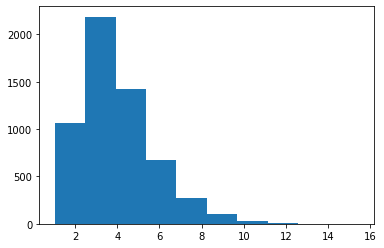

In [ ]:
_=plt.hist(target_df['int'])

In [ ]:
!nbdev_build_lib

Converted 00_models.ipynb.
Converted 01_psf.ipynb.
Converted 02_microscope.ipynb.
Converted 03_noise.ipynb.
Converted 04_pointsource.ipynb.
Converted 05_gmm_loss.ipynb.
Converted 06_plotting.ipynb.
Converted 07_file_io.ipynb.
Converted 08_dataset.ipynb.
Converted 09_output_trafo.ipynb.
Converted 10_evaluation.ipynb.
Converted 11_emitter_io.ipynb.
Converted 12_utils.ipynb.
Converted 13_train.ipynb.
Converted 15_fit_psf.ipynb.
Converted 16_visualization.ipynb.
Converted 17_eval_routines.ipynb.
Converted 18_predict_funcs.ipynb.
Converted 19_MERFISH_routines.ipynb.
Converted 20_MERFISH_visualization.ipynb.
Converted 21_MERFISH_routines_2.ipynb.
Converted 22_MERFISH_codenet.ipynb.
Converted hyper.ipynb.
Converted index.ipynb.
